# Transformer-Based Title Generation - Part 2

This project presents a Transformer-based sequence-to-sequence model designed to generate book titles from book descriptions. The model architecture closely follows the encoder-decoder pattern popularized by the original Transformer framework, enriched with refinements such as label smoothing, custom loss masking and dynamic hyperparameter optimization.  
  
At its core, the encoder processes the input description using token embeddings enriched with learnable positional encodings. The decoder generates the title autoregressively, guided by causal self-attention and encoder-decoder cross-attention mechanisms. Both encoder and decoder blocks use shared embeddings and incorporate residual connections, dropout regularization and layer normalization for stable training.  
  
A key highlight of this project is the integration of Optuna, an automated hyperparameter optimization framework. Optuna explores combinations of parameters such as embedding dimension, number of attention heads, model depth, dropout rate, learning rate and batch size. The objective function evaluates model performance using the ROUGE-1 score, a commonly used metric for evaluating short text generation tasks. It measures the overlap of unigrams (individual words) between the predicted and reference texts, making it well-suited for short outputs.  
  
To avoid GPU memory overflow (OOM) during training, especially with large parameter combinations, the hyperparameter search space is carefully constrained to smaller, memory-efficient configurations. The best-performing model is checkpointed and later used for inference with a custom generation function that decodes tokens step-by-step until an end-of-sequence token is reached.

## Load and Prepare Data

The first part of this project begins by importing the preprocessed datasets generated in the previous project "Transformer-Based Title Generation – Part 1".  
  
To prepare the data for training a Transformer-based model, we apply Byte Pair Encoding (BPE) for subword tokenization. BPE enables the model to handle rare and unknown words more effectively by breaking them into smaller, more frequent subunits. Special tokens such as pad, unk, sos and eos are added to the tokenizer to represent padding, unknown tokens, the start of a sequence and the end of a sequence, respectively.  
  
After tokenization, the sequences are further processed using the helper function create_decoder_inputs_and_targets(sequences, max_len, padding). This function separates the decoder input (which starts with sos and excludes eos) from the decoder target (which ends with eos and excludes sos). Padding is applied to ensure consistent input length across batches.  
  
This structured preparation ensures that the model receives properly formatted inputs and targets during training, laying a solid foundation for the encoder-decoder architecture that follows in the next stages.

In [1]:
import numpy as np
import pandas as pd

We're importing the preprocessed datasets made in Part 1.

In [2]:
df_train = pd.read_csv('/kaggle/input/train-book-data/train_book_data.csv')
df_valid = pd.read_csv('/kaggle/input/valid-book-data/valid_book_data.csv')
df_test = pd.read_csv('/kaggle/input/test-book-data/test_book_data.csv')

df_train.tail()

,Title,Description
1589,howl and other poems,"the prophetic poem, which was born by a genera..."
1590,crown of midnight (throne of glass #2),"""a line that should never be crossed is about ..."
1591,the cuckoo's calling (cormoran strike #1),a brilliant debut secret in a classic vein: a ...
1592,"saga, volume 2 (saga (collected editions) #2)",by the award-winning writer brian k. vaughan (...
1593,legend (legend #1),here there is an alternative title edition for...


The following code prepares training and validation data for further processing. It extracts the columns from df_train and df_valid and converts them to strings. The columns are then transformed into Python lists so that they can be used more easily in downstream tasks.

In [3]:
# Prepare data
train_titles = df_train["Title"].astype(str).tolist()
train_descriptions = df_train["Description"].astype(str).tolist()

valid_titles = df_valid["Valid_Title"].astype(str).tolist()
valid_descriptions = df_valid["Valid_Description"].astype(str).tolist()

This code defines a helper function add_sos_eos that adds special tokens sos (start of sequence) and eos (end of sequence) to a text string if they are not already present. These tokens are used in sequence-to-sequence models to signal the beginning and end of a sentence.  
  
The function is then applied to all elements in the train_titles list. This prepares the data for use in our model.

In [4]:
# Function to add <sos> (start of sequence) and <eos> (end of sequence) tokens
def add_sos_eos(text):
    text = text.strip()  # Remove leading and trailing whitespace
    if not text.startswith("<sos>"):  # Check if text already starts with <sos>
        text = f"<sos> {text}"  # Add <sos> at the beginning
    if not text.endswith("<eos>"):  # Check if text already ends with <eos>
        text = f"{text} <eos>"  # Add <eos> at the end
    return text

# Apply the function to all training titles
train_titles = [add_sos_eos(t) for t in train_titles]

### BPE (Byte Pair Encoding)

**Byte Pair Encoding (BPE)** is a subword tokenization technique that breaks words into smaller, more frequent units called subword tokens. Instead of treating each word as an atomic unit (as in traditional word-level tokenization), BPE starts with characters and gradually merges the most frequent adjacent pairs into new tokens, effectively learning a compact and expressive vocabulary.
  
BPE allows the model to handle rare or unseen words by decomposing them into known subwords. This reduces the number of out-of-vocabulary (OOV) tokens, which is crucial for robustness, especially when working with product data that may include brand names, technical terms or typos.  
With BPE, we can keep the vocabulary size relatively small without sacrificing the ability to represent complex words. This reduces memory usage and model complexity while maintaining flexibility.  
Because BPE reuses common subwords across many words ("phone", "headphone", "smartphone"), the model learns shared patterns more effectively. This improves generalization, especially in low-data settings.

In [5]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, AddedToken, trainers
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-07-20 15:17:52.947847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753024673.316941      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753024673.422981      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


The following code sets up a Byte-Pair Encoding (BPE) tokenizer using the tokenizers library (from Hugging Face).

With models.BPE() a new BPE tokenizer model is created. The Whitespace pre-tokenizer pre_tokenizers.Whitespace() splits the input text into words based on spaces before applying BPE. This step helps the BPE model work more effectively.  
The BPEDecoder is assigned to convert the tokenized output back into readable text (for evaluation and inference).  
  
This tokenizer will later be trained on text data and used to encode/decode sequences.

In [6]:
# Prepare the tokenizer
# Initialize a Byte-Pair Encoding (BPE) tokenizer model
bpe_tokenizer = Tokenizer(models.BPE())  

# Use whitespace to split text into initial tokens before BPE is applied
bpe_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()  

# Use a BPE decoder to reconstruct original text from token IDs
bpe_tokenizer.decoder = decoders.BPEDecoder()  

The following function computes how often each token appears in a list of texts, based on the tokenizer's pre-tokenization step. It will be used for analyzing vocabulary distribution.
  
**Input:**  
texts: a list of strings. 
tokenizer: a tokenizer object with a defined pre_tokenizer.  
  
**Token Extraction:**  
For each text string, the function uses the pre_tokenize_str method, which returns a list of tuples where each tuple contains a token and its character span in the original string.  
  
**Counting Tokens:**  
Only the actual token string (token[0]) is used to update the frequency count via a Counter.  
  
**Output:**  
A dictionary-like object mapping each token to the number of times it appears across all texts.

In [7]:
# Calculate token frequency
def calculate_token_frequencies(texts, tokenizer):
    # Create a Counter to store token frequencies
    token_counts = Counter()  
    
    for text in texts:
        tokens = tokenizer.pre_tokenizer.pre_tokenize_str(text)  # Apply the tokenizer's pre-tokenizer to split the text
        for token in tokens:
            token_counts[token[0]] += 1  # Count the occurrence of each token (token[0] contains the actual string)
            
    return token_counts  # Return the frequency dictionary

The following steps determine how many unique tokens should be included in the Byte-Pair Encoding (BPE) tokenizer’s vocabulary to cover most of the dataset.
  
**Combine Data:**  
train_titles and train_descriptions are merged to form one training corpus. Important because titles and descriptions could have different structures.  
**Token Frequency Calculation:**  
Uses the calculate_token_frequencies function to count how often each token appears based on whitespace tokenization.    
**Buffer for Subwords:**  
The number of unique tokens is used as the base vocabulary size. Since BPE can split rare or unknown words into subword units, the vocabulary size is increased to leave room for these subwords. This ensures the tokenizer can efficiently represent most of the data while also being flexible enough to handle rare or unknown terms.

In [8]:
# Combine texts (titles + descriptions)
train_texts = train_titles + train_descriptions

# Calculate vocabulary based on token frequencies using the previously defined function
token_counts = calculate_token_frequencies(train_texts, bpe_tokenizer)

# Vocab size with 20% buffer
vocab_size = int(len(token_counts) * 1.2)

The following code finalizes and trains the Byte-Pair Encoding (BPE) tokenizer using the prepared training data.  
  
**Special Tokens:** A list of special-purpose tokens is defined. These are used for:  
pad: Padding shorter sequences  
unk: Representing unknown words  
sos and eos: Marking the beginning and end of sequences  
The lstrip=False and rstrip=False ensures the tokens are treated as standalone (not merged with surrounding text). 
  
**Trainer Setup:** A BpeTrainer is initialized with:  
The vocabulary size calculated earlier.  
The list of special tokens to be included in the vocabulary.  
  
**Tokenizer Training:**  
The bpe_tokenizer.train_from_iterator(train_texts, trainer) function trains the tokenizer directly from the list of texts. It builds a BPE vocabulary and merge rules based on the token frequencies.
  
Once trained, this tokenizer can tokenize and encode any new text using the same subword rules learned from train_texts.

In [9]:
# Define special tokens to be added to the tokenizer
special_tokens = [
    AddedToken("<pad>", lstrip=False, rstrip=False),  # Padding token
    AddedToken("<unk>", lstrip=False, rstrip=False),  # Unknown token for unseen words
    AddedToken("<sos>", lstrip=False, rstrip=False),  # Start-of-sequence token
    AddedToken("<eos>", lstrip=False, rstrip=False),  # End-of-sequence token
]

# Initialize a BPE trainer with the desired vocabulary size and special tokens
trainer = trainers.BpeTrainer(
    vocab_size=vocab_size,
    special_tokens=special_tokens
)

# Train the BPE tokenizer on the combined training texts using the trainer
bpe_tokenizer.train_from_iterator(train_texts, trainer)

We can check the token IDs assigned to the special tokens after training our bpe_tokenizer using the .token_to_id() method.

In [10]:
# Print token IDs of the special tokens
print("Token IDs for special tokens:")
print("<pad>:", bpe_tokenizer.token_to_id("<pad>"))
print("<unk>:", bpe_tokenizer.token_to_id("<unk>"))
print("<sos>:", bpe_tokenizer.token_to_id("<sos>"))
print("<eos>:", bpe_tokenizer.token_to_id("<eos>"))

Token IDs for special tokens:
<pad>: 0
<unk>: 1
<sos>: 2
<eos>: 3


The following function bpe_encode takes a list of texts and uses the trained BPE tokenizer to encode each into a list of token IDs.  
Then, it pads all sequences to a specified max_length using post-padding (padding tokens are added to the end of each sequence).  
This ensures all sequences have the same length before being passed into a model.  
  
With max_len_desc max_len_title we calculate the maximum tokenized sequence lengths using the BPE tokenizer

In [11]:
# Function to encode text using the BPE tokenizer and pad sequences to a uniform length
def bpe_encode(texts, tokenizer, max_length):
    encodings = [tokenizer.encode(text).ids for text in texts]  # Encode each text and extract token IDs
    return pad_sequences(encodings, maxlen=max_length, padding='post')  # Pad sequences to max_length using post-padding


# Calculate maximum tokenized sequence lengths using the BPE tokenizer
max_len_desc = max(len(bpe_tokenizer.encode(text).ids) for text in train_descriptions + valid_descriptions)
max_len_title = max(len(bpe_tokenizer.encode(text).ids) for text in train_titles + valid_titles)

This block encodes and pads the training and validation datasets using the trained BPE tokenizer:  
  
**X_train / X_valid:** These are the inputs — encoded descriptions, padded to the maximum tokenized description length.  
**y_train_full / y_valid_full:** These are the targets — encoded titles, padded to the maximum tokenized title length.  
  
This prepares the data in a uniform shape suitable for training our sequence models.

In [12]:
# Encode and pad the training and validation data using the BPE tokenizer
X_train = bpe_encode(train_descriptions, bpe_tokenizer, max_len_desc) 
y_train_full = bpe_encode(train_titles, bpe_tokenizer, max_len_title)

X_valid = bpe_encode(valid_descriptions, bpe_tokenizer, max_len_desc)
y_valid_full = bpe_encode(valid_titles, bpe_tokenizer, max_len_title)

The following function prepares the target sequences for a sequence-to-sequence decoder, where the full encoded title sequences padded to max_len_title is used as input.  
  
The decoder input removes the last token (eos), so it becomes: ["sos", ..., token_n]  
The decoder target removes the first token (sos), so it becomes: [token_1, ..., "eos"]  
  
This shift allows the model to learn to predict the next token at each step. Thas's called **Teacher forcing**. It is a training strategy used in decoder-based models. At each time step during training, the model receives the true previous token (from the target sequence) as input — rather than using the token it predicted at the previous step. This makes training faster and more stable, because the model doesn't compound its own mistakes during early training.  

In [13]:
# Create decoder inputs and targets by shifting the sequences
def create_decoder_inputs_and_targets(sequences, max_len, padding):
    decoder_input = []
    decoder_target = []
    
    for seq in sequences:
        # Remove trailing padding zeros
        seq = [token for token in seq if token != 0]

        # Apply standard shift logic if the sequence is long enough
        if len(seq) >= 2:
            decoder_input.append(seq[:-1])   # Remove <eos>: used as input to decoder. It is what the decoder sees.
            decoder_target.append(seq[1:])   # Remove <sos>: expected target output. It is what the decoder predicts.
        else:
            # For very short sequences, append empty lists
            decoder_input.append([])
            decoder_target.append([])

    # Pad both sequences to the desired max length
    decoder_input_padded = pad_sequences(decoder_input, maxlen=max_len, padding=padding)
    decoder_target_padded = pad_sequences(decoder_target, maxlen=max_len, padding=padding)
    
    return decoder_input_padded, decoder_target_padded

Both sequences are padded to the same length (max_len_title - 1) to align with training requirements.

In [14]:
# Generate decoder input and target sequences for training and validation
decoder_input_train, decoder_target_train = create_decoder_inputs_and_targets(
    y_train_full, max_len=max_len_title - 1, padding='post'
)

decoder_input_valid, decoder_target_valid = create_decoder_inputs_and_targets(
    y_valid_full, max_len=max_len_title - 1, padding='post'
)

Let's check whether each sequence in y_train_full starts with the token ID 2 and ends with the token ID 3.

In [15]:
for i, seq in enumerate(y_train_full):
    if len(seq) == 0:
        print(f"Sequence {i} is empty.")
        continue

    # Find the last non-zero token (ignoring padding)
    last_nonzero = next((token for token in reversed(seq) if token != 0), None)

    if seq[0] != 2 or last_nonzero != 3:
        print(f"Sequence {i} does not start with 2 or end with 3 (last non-zero: {last_nonzero}): {seq}")

## Transformer Model
  
At the heart of this project lies a custom encoder-decoder Transformer model, specifically designed to generate book titles from book descriptions. Inspired by the original Transformer architecture introduced in 2017, this model leverages attention mechanisms and positional encoding to effectively capture both local and global dependencies in sequences — making it ideal for text generation tasks.
  
The model follows a sequence-to-sequence (seq2seq) structure composed of two primary components:

**Encoder**:  
The encoder takes in the book description (already tokenized and padded) and processes it through multiple Transformer layers. Each layer includes multi-head self-attention, residual connections, layer normalization and feedforward sub-networks. These layers enable the encoder to build a rich, contextual representation of the input.  
**Decoder**:  
The decoder receives the target sequence (starting with a <sos> token) and generates one token at a time. It includes both masked self-attention — preventing the model from seeing future tokens — and cross-attention layers that allow the decoder to attend to the encoder’s output. This dual attention mechanism ensures the decoder remains both autoregressive and context-aware.

**Highlights**:  
- A single embedding layer is shared between the encoder and decoder, ensuring consistent token representations and reducing the model’s memory footprint.  
- A specialized loss function is implemented to apply label smoothing while ignoring padding tokens — a critical technique for stabilizing training and improving generalization.  
- To avoid GPU memory issues, the model restricts certain hyperparameters (embedding dimension, number of layers/heads) to values that balance performance and hardware constraints.  

In [16]:
pip install nlpaug transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers

The function that follows generates a **padding mask** for sequences, which is critical for models like transformers that use self-attention.
  
It takes a batch of tokenized sequences (seq) as input. Then checks where tokens are equal to 0, which is the padding token ID.  
Returns a mask with:  
1.0 where padding exists (positions to ignore),  
0.0 elsewhere (valid tokens).  
  
The mask is reshaped to (batch_size, 1, 1, seq_len).  
This shape works with TensorFlow’s MultiHeadAttention layer as an additive mask, where +1.0 at padding positions will make attention logits very negative (after subtracting), effectively zeroing out attention to padding tokens.  
Without a mask, the model would attend to padding tokens — which are meaningless and could confuse the model.  

In [18]:
# Create a padding mask to ignore padding tokens during attention
@keras.utils.register_keras_serializable()  # Allows this function to be serialized with a Keras model
def create_padding_mask(seq):
    # Create a binary mask: 1.0 where the token is padding, 0.0 elsewhere
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # Reshape to (batch_size, 1, 1, seq_len) for broadcasting in MultiHeadAttention
    return mask[:, tf.newaxis, tf.newaxis, :]

The next function adds positional information to input embeddings so that the transformer model can understand the order of tokens in a sequence.  

Transformers, by design, process all tokens in parallel and do not inherently know their positions. So this function adds trainable **positional embeddings** to the token embeddings.
  
Explanation:  
positions = tf.range(...): Generates a list of positions from 0 to maxlen - 1.  
Embedding(...): Creates a layer where each position gets a learnable vector (same dimensionality as the token embeddings).  
x + pos_embeddings: Adds the positional embedding to each token embedding, so the model receives combined information (word + position).  
  
So if x is a tensor of shape (batch_size, sequence_length, embed_dim), the result after this function is a tensor of the same shape — but each token embedding now also contains positional context.

In [19]:
# Add positional encoding to input embeddings
@keras.utils.register_keras_serializable()  # Allows this function to be serialized with a Keras model
def add_positional_encoding(x, maxlen, embed_dim):
    # Generate position indices: [0, 1, 2, ..., maxlen-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)

    # Create a trainable embedding layer for positions
    pos_emb_layer = Embedding(input_dim=maxlen, output_dim=embed_dim)

    # Look up positional embeddings
    pos_embeddings = pos_emb_layer(positions)

    # Add positional embeddings to input embeddings
    return x + pos_embeddings

The following function defines a universal **Transformer block**, usable for both encoder and decoder layers. It's modular and configurable via masking options.  
  
1. **Multi-Head Attention**:  
Allows the model to attend to different parts of the sequence (or context) simultaneously. Can perform:  
Self-attention: when x == context  
Cross-attention: when x ≠ context (decoder attending to encoder outputs)  
Supports two kinds of masking:  
Padding mask: to ignore pad tokens  
Causal mask: to prevent looking ahead (used in decoder self-attention)
  
2. **Residual + Layer Normalization**:  
The attention output is added to the input (x) via a residual connection, helping with gradient flow and convergence. "Let the model learn something new, but also keep the original input." It prevents vanishing gradients in deep networks and allows easier flow of information from earlier layers to later layers. This way it helps the model learn refinements instead of completely new representations.  
LayerNormalization stabilizes training. It normalizes the values across the features within each training example. This stabilizes training by ensuring the outputs of layers have similar distributions and thus reduces the risk of exploding/vanishing activations.  
  
3. **Feed-Forward Network (FFN)**:  
Applies two Dense layers:  
First with ReLU activation (ff_dim size),  
Second to project back to embed_dim.  
This captures nonlinear transformations of each token independently.
  
4. **Second Residual + Layer Norm**:  
Adds the FFN output to the attention output (out1) — another residual connection.  
Ends with another LayerNormalization, completing the block.  

In [20]:
# Universal Transformer block with optional padding and causal masking
@keras.utils.register_keras_serializable()  # Allows this function to be serialized with a Keras model
def transformer_block(x, context, embed_dim, num_heads, ff_dim, dropout_rate, use_causal_mask=False, padding_mask=None):
    # Multi-head self-attention
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim,
        dropout=dropout_rate
    )(
        query=x, 
        value=context, 
        key=context, 
        attention_mask=padding_mask, 
        use_causal_mask=use_causal_mask
    )
    # x: used as the query
    # context: used as key and value:
    #   • In encoder self-attention: x == context
    #   • In decoder self-attention: x == context, with causal mask
    #   • In encoder-decoder attention: context is the encoder output
    # padding_mask: prevents attention to padding tokens
    # use_causal_mask: prevents attending to future tokens (for decoder self-attention)

    # Apply dropout and add residual connection
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    # Residual connection: adds original input `x` to attention output
    # Followed by Layer Normalization

    # Feed-forward network (position-wise)
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)

    # Second residual connection and normalization
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    # Second residual connection: output of attention + FFN
    # Final LayerNorm

The next function creates and returns a custom loss function for training language models that:  
- Smooths the labels (label smoothing)  
- Ignores padding tokens (masking)  
- Is compatible with Keras serialization  
  
This prevents the model from becoming too confident in its predictions and helps generalization and reduces overfitting.  
Instead of a "hard" 1-hot vector (e.g., [0, 0, 1, 0]), it produces a softer version (e.g., [0.01, 0.01, 0.96, 0.01]).  
Sequences are padded to a fixed length and padding tokens (ID=0) are not real data and should not influence training. So the mask ensures loss is only calculated on real tokens.

In [21]:
# Returns a custom loss function with label smoothing and masking for padding
def get_masked_label_smoothing_loss(smoothing):
    @keras.utils.register_keras_serializable()  # Allows this function to be serialized with a Keras model
    def loss_fn(y_true, y_pred):
        # Cast true labels to integers
        y_true = tf.cast(y_true, tf.int32)

        # Get vocabulary size from the prediction tensor's last dimension
        vocab_size = tf.shape(y_pred)[-1]

        # Convert true labels to one-hot encoding
        y_true_one_hot = tf.one_hot(y_true, vocab_size)

        # Apply label smoothing:
        #  - Distribute (smoothing) probability mass across all classes
        #  - Keep (1 - smoothing) on the correct class
        y_true_smoothed = y_true_one_hot * (1 - smoothing) + (smoothing / tf.cast(vocab_size, tf.float32))

        # Compute cross-entropy loss between smoothed labels and predictions
        loss = tf.keras.losses.categorical_crossentropy(y_true_smoothed, y_pred)

        # Create a mask to ignore padding tokens (padding ID = 0)
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)

        # Apply the mask to the loss
        loss *= mask

        # Return mean loss over non-padding tokens
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    
    return loss_fn

The following function create_encoder_decoder_transformer() defines a complete Transformer-based encoder-decoder model tailored for sequence-to-sequence tasks. It is designed to work with Optuna, a hyperparameter optimization framework, which automatically explores different configurations to find the best-performing model.  

The model follows the classical Transformer encoder-decoder structure. The encoder processes the input sequence and the decoder generates the target sequence, one token at a time. The encoder and decoder both receive tokenized sequences as input, where each token is represented by its corresponding integer ID. These inputs are fed into a shared embedding layer that maps each token ID to a dense vector of embedding dimension size. The model uses shared embeddings to save memory and ensure consistent token representations across both encoder and decoder.
  
At the beginning of the function, several hyperparameters are sampled using Optuna’s trial object. These include the number of **attention heads (num_heads)**, the **embedding dimension (embed_dim)**, the **size of the feedforward network** inside each Transformer block (ff_dim), the **number of Transformer layers (num_layers)**, the **dropout rate (dropout_rate)**, the **initial learning rate for the optimizer (initial_lr)**, the **label smoothing factor (smoothing)** and the **batch size (batch_size)**. One important constraint enforced here is that the embedding dimension must be divisible by the number of heads, which is necessary for multi-head attention to function correctly.  

The **learning rate schedule** defined here is effectively never used in practice. The reason is that the dataset is very small (only 1,593 training samples), so there aren't many training steps in total. With such a limited dataset, the model is prone to overfitting very quickly. If the learning rate decays during training, it would only make it harder for the optimizer to escape overfitting once it starts. In addition, with the current setting of decay_steps=10000 and staircase=True the learning rate will never decay at all, since training ends long before reaching 10,000 steps.  
For a meaningful schedule, both decay_steps and a final learning rate should also be part of the hyperparameter optimization. Only with a larger dataset would it make sense to experiment with an actual learning rate decay strategy. The initial_lr is still optimized.  
  
The encoder consists of a stack of Transformer blocks, each of which includes multi-head self-attention and a feedforward network. These blocks allow the model to learn dependencies between all tokens in the input sequence, regardless of their position.
  
The decoder is also composed of a stack of Transformer blocks but with a slightly different structure. Each decoder block first applies masked self-attention, which ensures that the decoder can only attend to earlier tokens in the sequence (**causal masking**). This is critical for autoregressive generation, where the model predicts one token at a time based on previously generated ones. After that, cross-attention is applied, where the decoder attends to the encoder’s output. This allows the decoder to focus on relevant parts of the input when generating each output token.
  
Padding masks are used in both the encoder and decoder to prevent the model from attending to padded positions in the sequences. These masks are passed into the attention layers and are essential for handling sequences of variable length in a batch.
  
After processing through the encoder and decoder, the output is passed through a final dense layer with a softmax activation to predict the probability distribution over the vocabulary for each position in the output sequence.
  
The model is compiled using the **Adam optimizer** with an exponentially decaying learning rate, which starts higher and decreases over time to stabilize training. The loss function used applies label smoothing (to avoid overconfidence in predictions) and masks out loss contributions from padded positions (to ensure padding tokens do not affect the gradients).
  
Finally, the function returns the compiled model along with the batch size sampled by Optuna. The use of K.clear_session() ensures that memory is properly cleared between trials.

In [22]:
@keras.utils.register_keras_serializable()  # Allows this function to be serialized with a Keras model
def create_encoder_decoder_transformer(trial):
    # Clear backend to avoid memory leaks in repeated trials
    K.clear_session() 
    
    # Define hyperparameter search space using Optuna
    num_heads = trial.suggest_categorical("num_heads", [2, 4])

    # Ensure that embed_dim is divisible by num_heads and <= 256
    valid_embed_dims = [d for d in range(96, 257, 32) if d % num_heads == 0]
    embed_dim = trial.suggest_categorical("embed_dim", valid_embed_dims)

    ff_dim = trial.suggest_int("ff_dim", 96, 160, step=16)
    num_layers = trial.suggest_int('num_layers', 2, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    initial_lr = trial.suggest_float("initial_lr", 1e-4, 5e-4, log=True)
    smoothing = trial.suggest_float('smoothing', 0.1, 0.3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])

    # Encoder and decoder input layers
    encoder_inputs = Input(shape=(max_len_desc,), name='encoder_inputs')
    decoder_inputs = Input(shape=(max_len_title - 1,), name='decoder_inputs')

    # Create padding masks for attention mechanisms
    enc_padding_mask = Lambda(create_padding_mask)(encoder_inputs)
    dec_padding_mask = Lambda(create_padding_mask)(decoder_inputs)

    # Shared token embedding layer for both encoder and decoder
    token_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)

    # --- Encoder ---
    x_enc = token_embedding(encoder_inputs)
    x_enc = add_positional_encoding(x_enc, max_len_desc, embed_dim)

    for _ in range(num_layers):
        # Transformer encoder block with self-attention: x = context = x_enc
        x_enc = transformer_block(
            x_enc, x_enc,
            embed_dim, num_heads, ff_dim, dropout_rate,
            padding_mask=enc_padding_mask
        )

    # --- Decoder ---
    x_dec = token_embedding(decoder_inputs)
    x_dec = add_positional_encoding(x_dec, max_len_title - 1, embed_dim)

    for _ in range(num_layers):
        # Masked self-attention: decoder looks only at previous tokens
        x_dec = transformer_block(
            x_dec, x_dec,
            embed_dim, num_heads, ff_dim, dropout_rate,
            use_causal_mask=True, # Cannot look into future
            padding_mask=dec_padding_mask
        )

        # Encoder-decoder attention: decoder focuses on encoder context: x = x_dec and context = x_enc
        x_dec = transformer_block(
            x_dec, x_enc,
            embed_dim, num_heads, ff_dim, dropout_rate,
            padding_mask=enc_padding_mask
        )

    # Final output layer: vocabulary distribution
    outputs = Dense(vocab_size, activation='softmax')(x_dec)

    # Build and compile the model
    model = Model([encoder_inputs, decoder_inputs], outputs)

    # Learning rate schedule with exponential decay --> schedule not used here, please see text above!
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=10000,
        decay_rate=0.1,
        staircase=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Loss with label smoothing and padding mask
    loss_fn = get_masked_label_smoothing_loss(smoothing)

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    return model, batch_size


## OPTUNA with ROUGE-Score
  
**Optuna** is a powerful framework for automated hyperparameter optimization, especially well-suited for deep learning models. When applied to natural language processing (NLP) tasks, it can explore a wide range of model configurations to improve evaluation metrics such as the **ROUGE score**. ROUGE stands for **Recall-Oriented Understudy for Gisting Evaluation**. It's a family of metrics widely used to evaluate automatic text generation tasks. It compares a generated text (our model’s output) against a reference or "gold standard". By using ROUGE instead of just validation loss, we're aligning model selection with actual generation performance — making the hyperparameter tuning much more meaningful. Specifically, we use the **ROUGE-1** score. A commonly used metric for evaluating short text generation tasks. It measures the overlap of unigrams (individual words) between the predicted and reference texts, making it well-suited for short, concise outputs. 
  
Typically, Optuna will try different values for architectural hyperparameters. Once a model is trained with a specific configuration, we evaluate it on a validation set and compute the ROUGE score. Optuna uses this score as the objective function to maximize, guiding it toward more effective model architectures.

However, our Optuna trial was failing because the model is too large to fit into GPU memory. This is commonly referred to as an Out of Memory (OOM) error.  
  
This typically happens when Optuna samples a combination of hyperparameters that results in a model with too many trainable parameters. The most common culprits are a very large embedding dimensions (512 or 1024), a high number of attention heads (which scale memory with embed_dim / num_heads) and too many Transformer layers in the encoder and decoder.  
All of these increase the model size quadratically or worse and memory usage can spike sharply.  

To prevent OOM errors and allow our optimization process to run reliably, we limit the upper bounds of memory-intensive hyperparameters. With these constraints, our model will be less likely to exceed available GPU memory and Optuna can run more trials without crashing. The results are smaller models, therefore we pair it with label smoothing, dropout and a good learning rate schedule.

In [23]:
pip install optuna-integration

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1720033671e34f06125745ae085f7bb43518c39c571a4f097e53c9ff0cda7894
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [25]:
import optuna
from rouge_score import rouge_scorer
import optuna.visualization as vis
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

The following code defines a full Optuna-compatible objective function for training and evaluating our Transformer model using ROUGE-1 as the evaluation metric. The goal is to tune hyperparameters to maximize the quality of generated text as measured by how well they match ground truth references.  

The code includes three main components:  
  
1. Decoding sequences of token IDs into readable text: **decode_sequences(pred_sequences, tokenizer):**  
A helper function that ensures that model outputs (which are sequences of token IDs) are converted back into plain text strings. It stops at the padding or end-of-sequence token (ID 0) and uses the tokenizer to decode the token list into text. This step is crucial before comparing generated output with reference texts using ROUGE.  
   
2. Calculating average ROUGE-1 score between model predictions and ground truth: **compute_avg_rouge_l_score(y_true_texts, y_pred_texts):**  
This function computes the average ROUGE-1 F1 score over a list of reference texts and predicted texts. ROUGE-1 measures the overlap of individual words between the predicted and reference texts, rewarding overlapping sequence.  
The use of use_stemmer=True ensures that inflectional variants like "run" and "running" are treated as similar, improving metric robustness.
  
3. Training the model, generating predictions and returning the evaluation score to Optuna: **seq2seq_objective(trial):**  
- This function calls our model-building function (create_encoder_decoder_transformer) that constructs a Transformer-based encoder-decoder model using hyperparameters suggested by Optuna and also returns the batch size.  
- **TFKerasPruningCallback** allows Optuna to stop unpromising trials early if validation loss doesn’t improve — saving time and GPU resources.  
- **EarlyStopping** ensures training ends early if no validation loss improvement is observed, and restores the best model weights.   
- decoder_input_train contains the decoder input tokens (starting with sos), while decoder_target_train contains the actual output tokens the model should learn to predict.  
- Validation data is used for early stopping and pruning.  
- After training, the model generates probability distributions over the vocabulary for each output token position.  
- **argmax** selects the most likely token at each step, resulting in a matrix of predicted token IDs.  
- The token sequences are decoded back into text using the earlier function, so ROUGE can compare strings.  
- The average ROUGE-1 score is computed for the batch of validation examples.  
- This score is returned to Optuna, which tries to maximize it.  

In [26]:
def decode_sequences(pred_sequences, tokenizer):
    texts = []
    for seq in pred_sequences:
        if isinstance(seq, np.ndarray):
            seq = seq.tolist()  # Ensure the sequence is a list

        # Cut the sequence at the first padding or end-of-sequence token (ID = 0)
        try:
            end_idx = seq.index(0)
            seq = seq[:end_idx]
        except ValueError:
            pass  # No padding found; use full sequence

        # Convert token IDs to text, skipping special tokens like <pad>, <sos>, <eos>
        texts.append(tokenizer.decode(seq, skip_special_tokens=True))
    return texts


def compute_avg_rouge_1_score(y_true_texts, y_pred_texts):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    scores = []
    for ref, pred in zip(y_true_texts, y_pred_texts):
        score = scorer.score(ref, pred)['rouge1'].fmeasure
        scores.append(score)
    return np.mean(scores)

def seq2seq_objective(trial):
    model, batch_size = create_encoder_decoder_transformer(trial)

    callbacks = [
        TFKerasPruningCallback(trial, 'val_loss'), 
        EarlyStopping(patience=7, monitor='val_loss', restore_best_weights=True)
    ]

    model.fit(
        [X_train, decoder_input_train],
        decoder_target_train,
        validation_data=([X_valid, decoder_input_valid], decoder_target_valid),
        epochs=8,  # 8 epochs are eoungh because the dataset is small an we want to prevent overfitting
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # model generates probability distributions over the vocabulary
    predictions = model.predict([X_valid, decoder_input_valid], batch_size=batch_size)
    predicted_ids = np.argmax(predictions, axis=-1)

    # token sequences are decoded back into text 
    predicted_texts = decode_sequences(predicted_ids, bpe_tokenizer)
    reference_texts = decode_sequences(decoder_target_valid, bpe_tokenizer)

    # average ROUGE-1 score is computed for the batch of validation examples
    avg_rouge = compute_avg_rouge_1_score(reference_texts, predicted_texts)

    # score is returned to Optuna, which tries to maximize it
    return avg_rouge

With **optuna.create_study(direction="maximize")** we create a new optimization study object. We specify direction="maximize" because the goal is to maximize the average ROUGE-1 score returned by our seq2seq_objective() function.  
This study will keep track of trials, monitor the best score so far and allow us to inspect results later.
  
**study.optimize(seq2seq_objective, n_trials=x)** triggers the optimization loop for n_trials. Optuna will run x different model configurations.  
In each trial Optuna samples a set of hyperparameters (like embed_dim, num_heads, dropout_rate, etc.). The seq2seq_objective() function builds and trains the model using those settings. It then decodes predictions and computes the average ROUGE-1 score on the validation set. That score is reported back to Optuna as the trial's objective value.  
Optuna uses this feedback to explore more promising regions of the search space in later trials.

In [27]:
study = optuna.create_study(direction="maximize")
study.optimize(seq2seq_objective, n_trials=5)

# Display the best hyperparameters found
print('Best hyperparameters: ', study.best_params)

# Display the best average ROUGE score achieved
print('Best avg_rouge: ', study.best_value)

[I 2025-07-20 15:19:22,974] A new study created in memory with name: no-name-ab9a42fe-a843-4b8f-af0a-165d93e3ebf5
I0000 00:00:1753024765.572945      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753024765.573667      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/8


I0000 00:00:1753024793.062209     104 service.cc:148] XLA service 0x7faa7c00c820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753024793.063779     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753024793.063797     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753024795.339133     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753024815.485146     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 136s 445ms/step - accuracy: 0.0159 - loss: 8.2658 - val_accuracy: 0.0035 - val_loss: 8.3035
Epoch 2/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 370ms/step - accuracy: 0.0334 - loss: 7.0656 - val_accuracy: 0.0162 - val_loss: 8.2023
Epoch 3/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 367ms/step - accuracy: 0.0490 - loss: 6.5693 - val_accuracy: 0.0182 - val_loss: 8.2227
Epoch 4/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 366ms/step - accuracy: 0.0582 - loss: 6.2217 - val_accuracy: 0.0253 - val_loss: 8.0609
Epoch 5/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 368ms/step - accuracy: 0.0612 - loss: 6.0167 - val_accuracy: 0.0257 - val_loss: 8.0848
Epoch 6/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 369ms/step - accuracy: 0.0692 - loss: 5.7181 - val_accuracy: 0.0253 - val_loss: 8.1824
Epoch 7/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 370ms/step - accuracy: 0.0754 - loss: 5.5147 - val_accuracy: 0.0245 - val_loss: 8.2023
Epoch 8/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 370ms/step - accuracy: 0.0861 - loss: 5.2375 - val_accur

[I 2025-07-20 15:30:28,694] Trial 0 finished with value: 0.02078787878787879 and parameters: {'num_heads': 4, 'embed_dim': 256, 'ff_dim': 128, 'num_layers': 2, 'dropout_rate': 0.3119638403630194, 'initial_lr': 0.0004017722178202516, 'smoothing': 0.28319536438853843, 'batch_size': 8}. Best is trial 0 with value: 0.02078787878787879.


Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 124s 625ms/step - accuracy: 0.0106 - loss: 9.5747 - val_accuracy: 0.0000e+00 - val_loss: 9.0738
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 297ms/step - accuracy: 0.0167 - loss: 8.5785 - val_accuracy: 0.0000e+00 - val_loss: 8.5350
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 296ms/step - accuracy: 0.0167 - loss: 7.8331 - val_accuracy: 0.0000e+00 - val_loss: 8.2818
Epoch 4/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.0167 - loss: 7.4089 - val_accuracy: 0.0000e+00 - val_loss: 8.2227
Epoch 5/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.0170 - loss: 7.2536 - val_accuracy: 1.6667e-04 - val_loss: 8.2009
Epoch 6/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.0220 - loss: 7.1552 - val_accuracy: 0.0037 - val_loss: 8.1307
Epoch 7/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 288ms/step - accuracy: 0.0262 - loss: 7.0826 - val_accuracy: 0.0048 - val_loss: 8.0645
Epoch 8/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 288ms/step - accuracy: 0.0

[I 2025-07-20 15:36:05,571] Trial 1 finished with value: 0.024136363636363633 and parameters: {'num_heads': 2, 'embed_dim': 96, 'ff_dim': 112, 'num_layers': 3, 'dropout_rate': 0.16991901568662465, 'initial_lr': 0.0001063424846168355, 'smoothing': 0.24867264327584324, 'batch_size': 16}. Best is trial 1 with value: 0.024136363636363633.


Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.0154 - loss: 8.6039 - val_accuracy: 0.0000e+00 - val_loss: 8.1665
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 841ms/step - accuracy: 0.0217 - loss: 6.9301 - val_accuracy: 0.0105 - val_loss: 8.0301
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 833ms/step - accuracy: 0.0371 - loss: 6.4795 - val_accuracy: 0.0127 - val_loss: 7.8999
Epoch 4/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 827ms/step - accuracy: 0.0442 - loss: 6.2150 - val_accuracy: 0.0060 - val_loss: 8.0685
Epoch 5/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 831ms/step - accuracy: 0.0452 - loss: 6.1113 - val_accuracy: 0.0148 - val_loss: 8.0182
Epoch 6/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 834ms/step - accuracy: 0.0473 - loss: 6.0045 - val_accuracy: 0.0150 - val_loss: 8.0552
Epoch 7/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 835ms/step - accuracy: 0.0499 - loss: 5.8853 - val_accuracy: 0.0178 - val_loss: 8.1299
Epoch 8/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 833ms/step - accuracy: 0.0481 - loss: 5.8695 

[I 2025-07-20 15:49:06,648] Trial 2 finished with value: 0.01500865800865801 and parameters: {'num_heads': 4, 'embed_dim': 160, 'ff_dim': 112, 'num_layers': 3, 'dropout_rate': 0.38441584404767315, 'initial_lr': 0.0004708707267234865, 'smoothing': 0.20519753407428126, 'batch_size': 16}. Best is trial 1 with value: 0.024136363636363633.


Epoch 1/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.0126 - loss: 9.3495 - val_accuracy: 0.0000e+00 - val_loss: 8.5253
Epoch 2/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.0167 - loss: 7.7421 - val_accuracy: 0.0000e+00 - val_loss: 8.2559
Epoch 3/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.0191 - loss: 7.1882 - val_accuracy: 0.0042 - val_loss: 8.1924
Epoch 4/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.0300 - loss: 6.9880 - val_accuracy: 0.0137 - val_loss: 8.0090
Epoch 5/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.0392 - loss: 6.7860 - val_accuracy: 0.0185 - val_loss: 7.8409
Epoch 6/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.0492 - loss: 6.5054 - val_accuracy: 0.0208 - val_loss: 7.8498
Epoch 7/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.0544 - loss: 6.2724 - val_accuracy: 0.0243 - val_loss: 7.7706
Epoch 8/8
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.0593 - loss: 6.0895 - val_accuracy: 0.0255 - val_loss

[I 2025-07-20 15:57:36,501] Trial 3 finished with value: 0.040728354978354975 and parameters: {'num_heads': 2, 'embed_dim': 192, 'ff_dim': 128, 'num_layers': 3, 'dropout_rate': 0.3315688244224434, 'initial_lr': 0.000441391965261028, 'smoothing': 0.24813453584489864, 'batch_size': 64}. Best is trial 3 with value: 0.040728354978354975.


Epoch 1/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 131s 422ms/step - accuracy: 0.0159 - loss: 8.5559 - val_accuracy: 0.0063 - val_loss: 8.0363
Epoch 2/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 62s 308ms/step - accuracy: 0.0355 - loss: 6.7849 - val_accuracy: 0.0195 - val_loss: 7.8575
Epoch 3/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 59s 297ms/step - accuracy: 0.0517 - loss: 6.2955 - val_accuracy: 0.0240 - val_loss: 7.7504
Epoch 4/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 299ms/step - accuracy: 0.0588 - loss: 5.9336 - val_accuracy: 0.0282 - val_loss: 7.7042
Epoch 5/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 300ms/step - accuracy: 0.0666 - loss: 5.6606 - val_accuracy: 0.0300 - val_loss: 7.6847
Epoch 6/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 300ms/step - accuracy: 0.0722 - loss: 5.3810 - val_accuracy: 0.0290 - val_loss: 7.6992
Epoch 7/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 301ms/step - accuracy: 0.0774 - loss: 5.1417 - val_accuracy: 0.0305 - val_loss: 7.6828
Epoch 8/8
200/200 ━━━━━━━━━━━━━━━━━━━━ 60s 301ms/step - accuracy: 0.0828 - loss: 4.9553 -

[I 2025-07-20 16:06:58,052] Trial 4 finished with value: 0.05017532467532467 and parameters: {'num_heads': 4, 'embed_dim': 192, 'ff_dim': 112, 'num_layers': 2, 'dropout_rate': 0.12395474756144638, 'initial_lr': 0.0002057299316110685, 'smoothing': 0.2324882314383764, 'batch_size': 8}. Best is trial 4 with value: 0.05017532467532467.


Best hyperparameters:  {'num_heads': 4, 'embed_dim': 192, 'ff_dim': 112, 'num_layers': 2, 'dropout_rate': 0.12395474756144638, 'initial_lr': 0.0002057299316110685, 'smoothing': 0.2324882314383764, 'batch_size': 8}
Best avg_rouge:  0.05017532467532467


Our Transformer model training through Optuna shows some progress over the trials.

With **best_trial = study.best_trial** we retrieve the best trial from the study — that is, the one that achieved the highest average ROUGE-1 score across all evaluated configurations. With this object we'll recreate the model exactly as it was during that best run.  

**best_model, best_batch_size = create_encoder_decoder_transformer(best_trial)** calls our model-building function again, using the best trial's parameters.
  
Since we are passing the best_trial, the same architecture and hyperparameter configuration that gave us the best performance before will now be reproduced.

In [28]:
# Best Trial
best_trial = study.best_trial

# Recreate best model
best_model, best_batch_size = create_encoder_decoder_transformer(best_trial)

In this phase of the project, the encoder-decoder Transformer model is trained using the best hyperparameters identified through Optuna. We will train the model with the best hyperparameters using two important Keras callbacks: ModelCheckpoint and EarlyStopping.  
  
The **ModelCheckpoint** callback is configured to monitor the validation loss (val_loss) during training. It saves the model only when a new minimum in validation loss is reached, ensuring that only the best-performing model across all epochs is preserved. This best model is stored in the file best_model.keras, which can later be reloaded.  
  
The **EarlyStopping** callback monitors the same validation loss metric and halts training if no improvement is observed over a specified number of epochs. This prevents unnecessary training beyond the point of optimal performance. Moreover, the parameter restore_best_weights=True ensures that once training stops early, the model reverts to the weights from the epoch with the best validation performance.  
  
The training itself is conducted by fitting the model to a pair of input datasets: the encoder input (X_train, the descriptions) and the decoder input (decoder_input_train, the target sequence without the final token). The model learns to predict the correct next tokens (decoder_target_train) during training. The validation data serves to monitor the model’s generalization capabilities and guide the callbacks.  
  
The batch size used here comes from the best-performing Optuna trial, helping to balance memory usage and performance.

In [29]:
# Define the ModelCheckpoint callback to save the model with the best validation loss
checkpoint = ModelCheckpoint(
    'best_model.keras',       # File path where the best model will be saved
    monitor='val_loss',       # Monitor validation loss
    mode='min',               # Lower val_loss = better performance
    save_best_only=True,      # Only save if this epoch is better than previous ones
    verbose=1                 # Print when the model is saved
)


# Callbacks: Pruning und optional EarlyStopping
callbacks = [
    EarlyStopping(patience=3,   # If training doesn’t improve for x consecutive epochs, training stops early
    monitor='val_loss',         
    restore_best_weights=True), # Ensures the model reverts to the best-performing epoch (not the final one)
    checkpoint
]

history = best_model.fit(
    [X_train, decoder_input_train],      # Encoder and decoder inputs
    decoder_target_train,                # Decoder target output
    validation_data=([X_valid, decoder_input_valid], decoder_target_valid),
    epochs=15,
    batch_size=best_batch_size,          # Batch size from the best Optuna trial
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.0159 - loss: 8.5797
Epoch 1: val_loss improved from inf to 8.05147, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 121s 407ms/step - accuracy: 0.0160 - loss: 8.5760 - val_accuracy: 0.0037 - val_loss: 8.0515
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.0349 - loss: 6.7848
Epoch 2: val_loss improved from 8.05147 to 7.91387, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 313ms/step - accuracy: 0.0349 - loss: 6.7843 - val_accuracy: 0.0160 - val_loss: 7.9139
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.0518 - loss: 6.2723
Epoch 3: val_loss improved from 7.91387 to 7.85449, saving model to best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 303ms/step - accuracy: 0.0518 - loss: 6.2719 - val_accuracy: 0.0185 - val_loss: 7.8545
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.0597 - loss: 5.9172
Epoch 4: val_loss improved from 7.85

We plot training and validation accuracy as well as training and validation loss to see how closely the validation cuves are tracking the training curves.

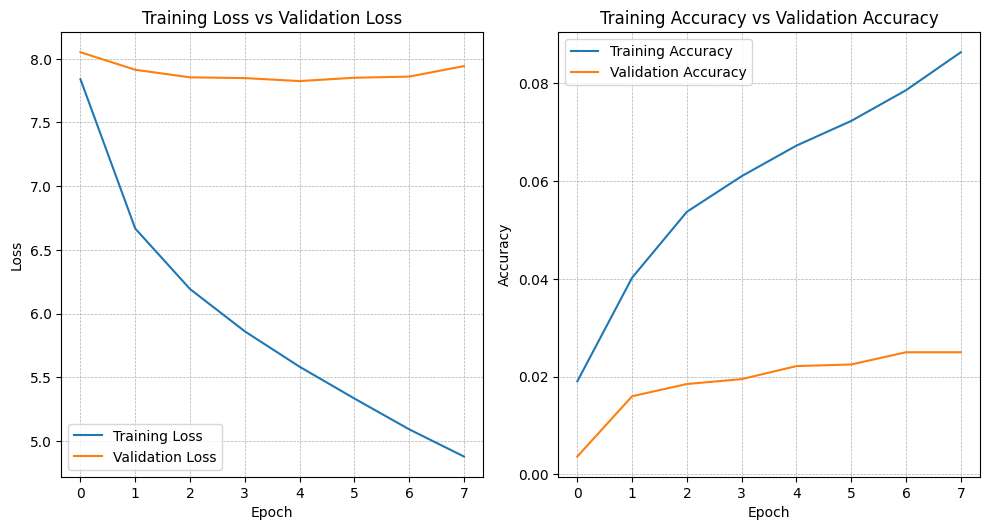

In [30]:
# Function to plot Loss and Accuracy
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy from the history object.

    Parameters:
    history (History): The history object returned by the fit method of a Keras model.
    """
    fig = plt.figure(figsize=(10, 10), facecolor='white')

    # Plotting Loss
    ax1 = fig.add_subplot(2, 2, 1, facecolor='white')
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.legend(facecolor='white')
    ax1.set_title('Training Loss vs Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Plotting Accuracy
    ax2 = fig.add_subplot(2, 2, 2, facecolor='white')
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.legend(facecolor='white')
    ax2.set_title('Training Accuracy vs Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In the early epochs, there is an improvement in validation loss and accuracy. This indicates that the model was able to learn and generalize in the initial phases of training.   
Then the improvements in validation loss become smaller.

We will load the best model. Because of these @register_keras_serializable() decorators we used earlier, Keras knows how to serialize and deserialize them properly and we do not need to manually pass them again when calling load_model().

In [31]:
# Load best model from file
tform_model = load_model('best_model.keras')

## Test Texts
  
The following function generate_title takes an input description and generates a title. It first encodes the description using the Byte-Pair Encoding (BPE) tokenizer, making sure it matches the expected input length for the encoder. It also retrieves the special sos (start-of-sequence) and eos (end-of-sequence) token IDs that mark the beginning and end of the title generation process.  
  
The decoding process is performed step-by-step in a loop. It starts with a decoder input initialized with the sos token. At each step, the function pads the current decoder input (to ensure a consistent shape), passes it together with the encoded description to the model and selects the most probable next token using argmax over the predicted probability distribution.   
  
If the model predicts the eos token, the loop stops early. Otherwise, the predicted token is appended to the decoder input and decoding continues.  
  
After decoding is complete, the function converts the predicted token IDs back into strings using the tokenizer and reconstructs the final title text. BPE token artifacts (like ▁ used to indicate spaces) are removed, and the final title is cleaned and returned.

In [32]:
def generate_title(description_text, tokenizer, model, max_len_desc, max_len_title):
    # Tokenize and pad the input description
    input_ids = bpe_encode([description_text], tokenizer, max_len_desc)

    # Get the special token IDs
    sos_id = tokenizer.token_to_id("<sos>")
    eos_id = tokenizer.token_to_id("<eos>")
    assert sos_id is not None and eos_id is not None, "Special tokens missing in tokenizer!"

    # Start the decoder input with the <sos> token
    decoder_input = [sos_id]

    for i in range(max_len_title):
        # Pad the decoder input to match the required input shape
        padded_decoder_input = tf.keras.preprocessing.sequence.pad_sequences(
            [decoder_input],
            maxlen=max_len_title - 1,
            padding='post'
        )

        # Predict the next token probabilities
        predictions = model.predict([input_ids, padded_decoder_input], verbose=0)

        # Select the token with the highest probability at the current decoding position
        current_pos = len(decoder_input) - 1
        next_token_id = np.argmax(predictions[0][current_pos])

        # If end-of-sequence token is predicted, stop generation
        if next_token_id == eos_id:
            break

        # Otherwise, append the token and continue decoding
        decoder_input.append(next_token_id)

    # Convert token IDs to string tokens and reconstruct the final title
    tokens = [tokenizer.id_to_token(id) for id in decoder_input[1:]]  # skip <sos>
    return " ".join(tokens).replace("▁", " ").strip()

Now let's see how our Transformer model performs on the test data.

In [33]:
# Loop over the first 3 test descriptions and generate titles
for i in range(3):
    sample_description = df_test.loc[i, 'Test_Description']
    original_title = df_test.loc[i, 'Test_Title']  
    
    generated_title = generate_title(
        model=tform_model,
        tokenizer=bpe_tokenizer,
        description_text=sample_description,
        max_len_desc=max_len_desc,
        max_len_title=max_len_title
    )
    
    print(f"Original Description #{i+1}:\n{sample_description}\n")
    print(f"Original Title #{i+1}: {original_title}\n")
    print(f"Generated Title #{i+1}: {generated_title}\n")
    print("-" * 80)

Original Description #1:
starting over sucks.when we moved to west virginia right before my senior year, i'd pretty much resigned myself to thick accents, dodgy internet access, and a whole lot of boring… until i spotted my hot neighbor, with his looming height and eerie green eyes. things were looking up.and then he opened his mouth.daemon is infuriating. arrogant. stab-worthy. we do not get alon starting over sucks.when we moved to west virginia right before my senior year, i'd pretty much resigned myself to thick accents, dodgy internet access, and a whole lot of boring… until i spotted my hot neighbor, with his looming height and eerie green eyes. things were looking up.and then he opened his mouth.daemon is infuriating. arrogant. stab-worthy. we do not get along. at all. but when a stranger attacks me and daemon literally freezes time with a wave of his hand, well, something… unexpected happens. the hot alien living next door marks me.you heard me. alien. turns out daemon and his 

The model consistently outputs the same phrase, indicating a generation failure.
  
Title generation is inherently difficult, as book titles are often creative, abstract and sometimes loosely related to the description. The model was trained on a very small dataset, limiting its ability to generalize or learn title styles effectively.
The architecture was constrained by limited computing resources, which further restricted training depth and capacity.
  
Given the limitations — small data, limited compute and the creative nature of the task — these results are understandable.